# DIABETES PREDICTION 

### Importing all the libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns


from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix 


import plotly.express as px
import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

## Now we are going to load our dataset

In [33]:
df = pd.read_csv('diabetes.csv')

## Handling Invalid Zero Values

In [34]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# as we know these particular columns entries can't be 0... that's why we are replacing 0 with NaN here
df[columns_with_zeros] = df[columns_with_zeros].replace(0, pd.NA)

In [35]:
# now we are filling NaN values with the median of each column
df[columns_with_zeros] = df[columns_with_zeros].fillna(df[columns_with_zeros].median())

In [36]:
df.head()

# Printing the top five rows to get an overview of the dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [37]:
df.shape

# This shows the dataset dimensions: 768 rows represent patients and 9 columns represent features
# Along with one target column i.e. "Outcome"

(768, 9)

In [38]:
df.describe()

# The describe function gives statistical measures like mean, standard deviation, minimum, and maximum
# This helps in understanding the range and distribution of the data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [39]:
df['Outcome'].value_counts()

# This tells us the outcome values
# It shows how many patients are diabetic versus non-diabetic

Outcome
0    500
1    268
Name: count, dtype: int64

In [40]:
df.groupby('Outcome').mean()

# This shows the difference in average feature levels between diabetic and non-diabetic patients
# Diabetic patients have higher glucose levels, which is a pattern learned by the model

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.682000,70.920000,27.726000,127.792000,30.885600,0.429734,31.190000
1,4.865672,142.130597,75.123134,31.686567,164.701493,35.383582,0.550500,37.067164


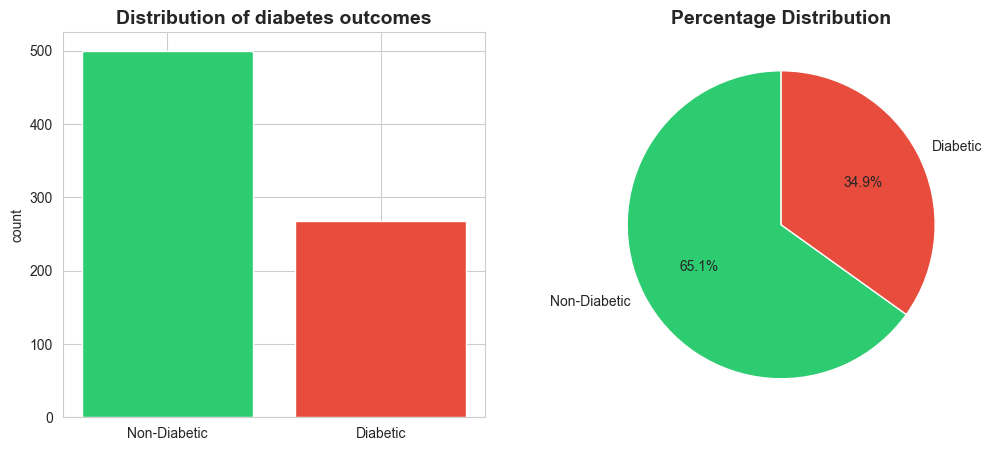

In [41]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
outcome_counts = df['Outcome'].value_counts()
plt.bar(['Non-Diabetic','Diabetic'], outcome_counts.values, color=['#2ecc71', '#e74c3c'])
plt.title('Distribution of diabetes outcomes', fontsize=14, fontweight='bold')
plt.ylabel('count')

plt.subplot(1,2,2)
plt.pie(outcome_counts.values, labels=['Non-Diabetic', 'Diabetic'], autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)

plt.title('Percentage Distribution', fontsize=14, fontweight='bold')
plt.show()

# These visualizations represent the distribution of diabetic and non-diabetic patients
# About 65% are non-diabetic and 35% are diabetic

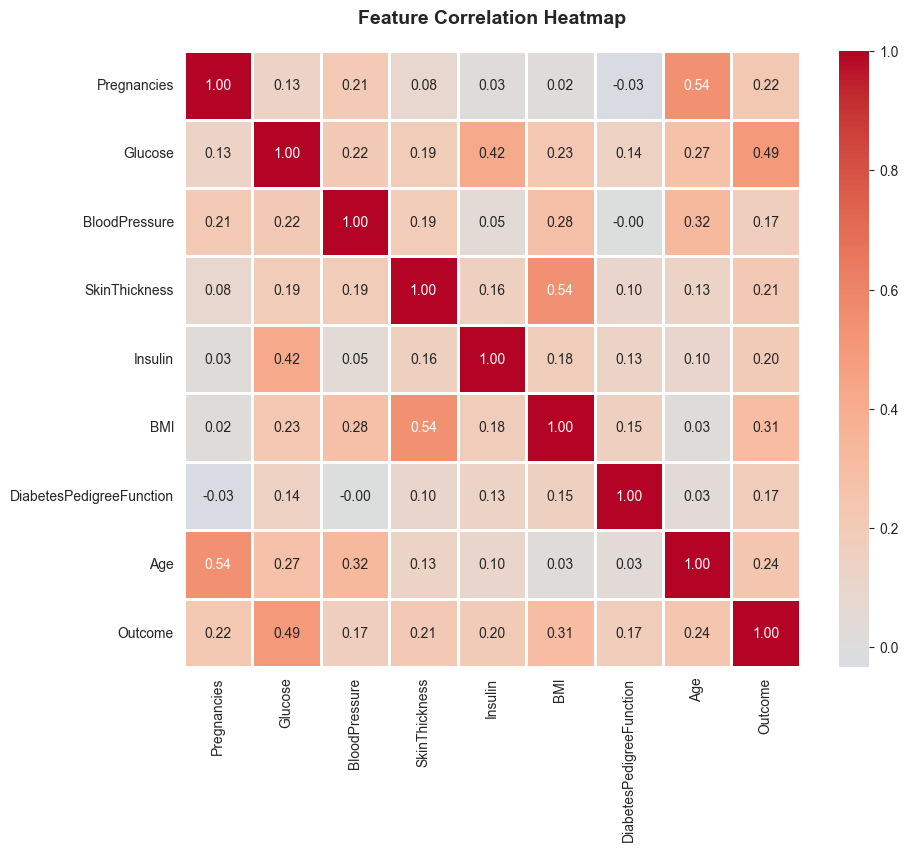

In [42]:
plt.figure(figsize=(10,8))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1, fmt='.2f')
plt.title('Feature Correlation Heatmap', fontsize = 14, pad=20, fontweight='bold')
plt.show()

# A correlation heatmap is created to show the relationships between features
# Glucose has the highest correlation with the outcome (0.47)
# This indicates that glucose is a very important feature for prediction

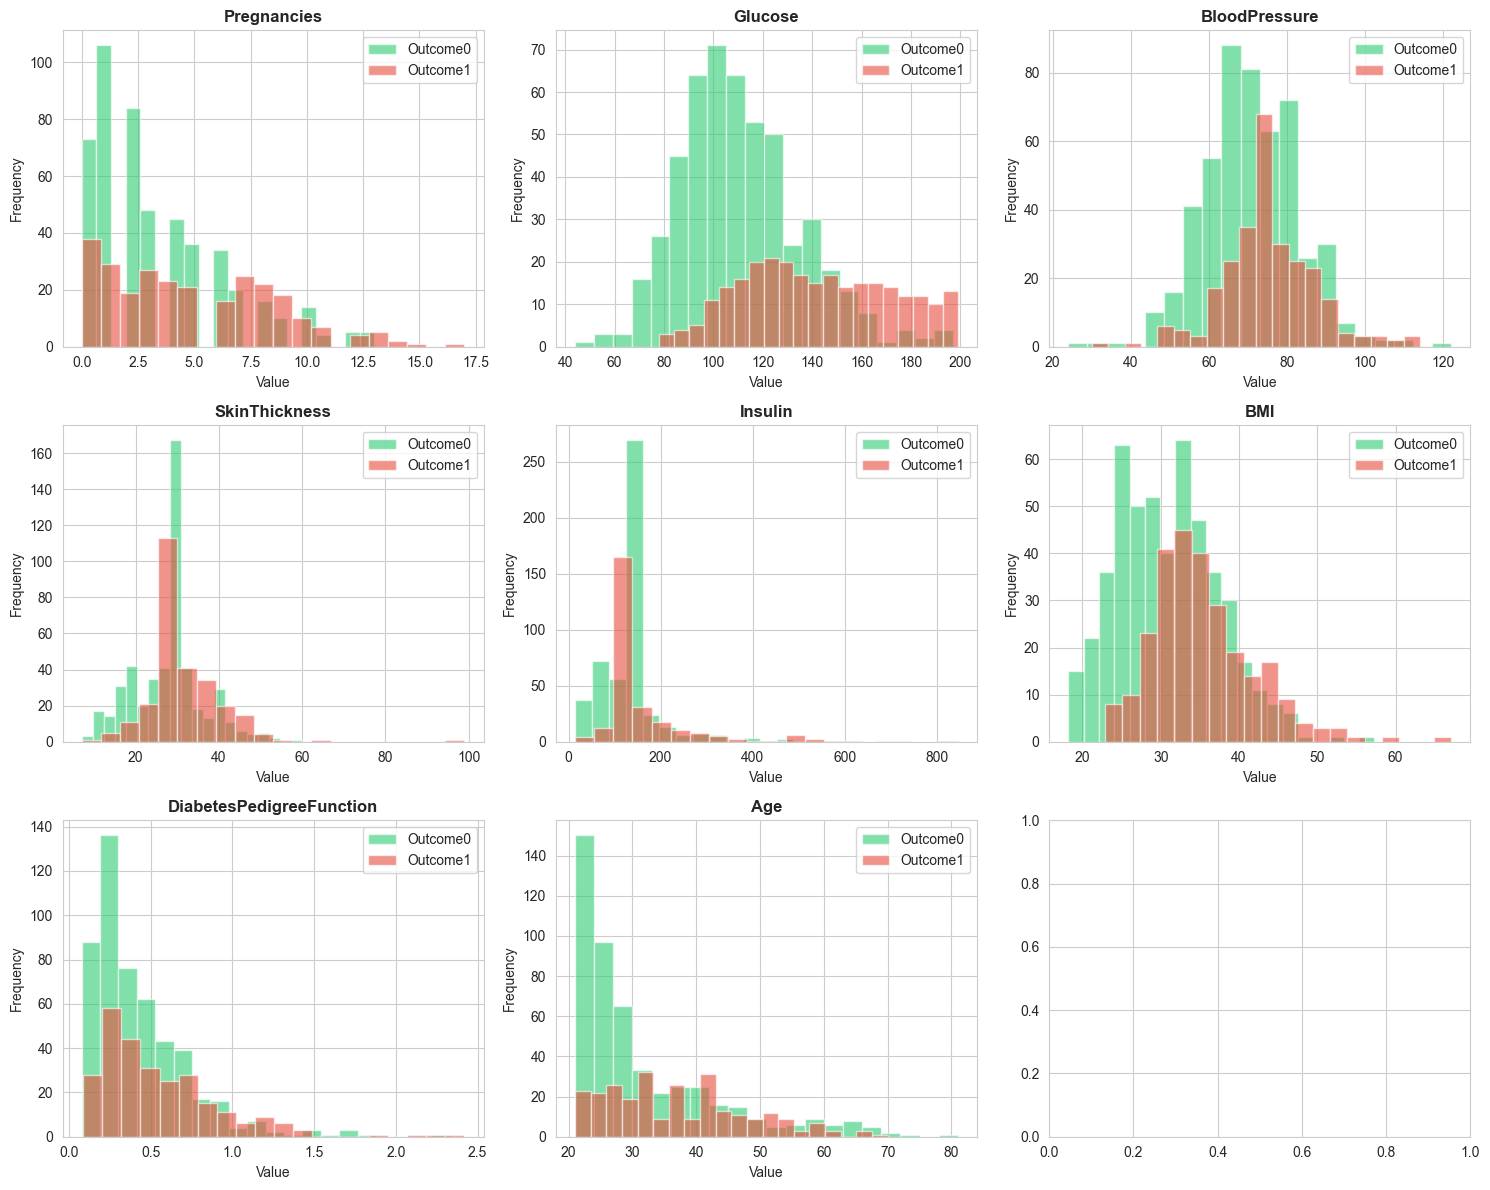

In [43]:
fig, axes = plt.subplots(3,3 , figsize=(15,12))
features = df.columns[:-1]

for idx, feature in enumerate(features):
    row, col = idx//3, idx % 3
    for outcome in [0,1]:
        data = df[df['Outcome'] == outcome][feature]
        axes[row,col].hist(data, alpha=0.6, bins=20, label=f'Outcome{outcome}', color =['#2ecc71', '#e74c3c'][outcome])
        
        axes[row,col].set_title(feature, fontweight='bold')
        axes[row, col].set_xlabel('Value')
        axes[row, col].set_ylabel('Frequency')
        axes[row,col].legend()

plt.tight_layout()
plt.show()  


# Histograms display the feature distributions for diabetic (red) and non-diabetic (green) patients
# Higher glucose levels indicate a higher probability of being diabetic

In [44]:
# Separating the features (X) and the target variable (Y)

x = df.drop(columns='Outcome', axis=1)
y = df['Outcome']


x.head()
# y.head()

# X includes the 8 feature columns used for prediction
# Y represents the target outcome, where 0 = non-diabetic and 1 = diabetic


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [45]:
# feature scaling
scaler = StandardScaler()
x = scaler.fit_transform(x)
x

# StandardScaler is used to transform all features to have a mean of 0 and a standard deviation of 1
# After standardization, all features are on the same scale, so the model treats them fairly
# The .fit_transform method learns the mean and standard deviation from the data and applies the transformation

array([[ 0.63994726,  0.86604475, -0.03198993, ...,  0.16661938,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20506583, -0.5283186 , ..., -0.85219976,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.01666174, -0.69376149, ..., -1.33250021,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.02157407, -0.03198993, ..., -0.910418  ,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14279979, -1.02464727, ..., -0.34279019,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94206766, -0.19743282, ..., -0.29912651,
        -0.47378505, -0.87137393]], shape=(768, 8))

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, stratify=y, random_state=2)

print(x.shape)
print(x_train.shape)
print(x_test.shape)

# Here we are splitting our data
# We are using 80% for training and 20% for testing
# stratify=y keeps the same ratio of diabetic and non-diabetic samples in both sets
# random_state ensures reproducibility

# Total samples = 768
# Training samples = 614
# Testing samples = 154

(768, 8)
(614, 8)
(154, 8)


# Model 1 - SVM (Support Vector Machine)

In [47]:
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)

# Training a Support Vector Machine (SVM) classifier
# Initializing the SVM model with a linear kernel
# Fitting the model to the training data so it can learn patterns

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [48]:
y_pred_svm = svm_model.predict(x_test)

## Evaluating the model

In [49]:
# Calculating the accuracy score for the SVM model

AccuracyScore_svm = accuracy_score(y_test, y_pred_svm)
AccuracyScore_svm

# t# The model achieves around 77% to 78% accuracy on the test data, not bad.

0.7727272727272727

In [50]:
# Calculating precision, recall, and F1-score for the SVM model

PrecisionScore_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# Printing the precision, recall, and F1-score values

print(PrecisionScore_svm)
print(recall_svm)
print(f1_svm)

0.7567567567567568
0.5185185185185185
0.6153846153846154


In [51]:
# Calculating the confusion matrix for the SVM model

ConfusionMatrix_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrix_svm

# The confusion matrix shows where the model is making correct predictions and where it is making errors

array([[91,  9],
       [26, 28]])

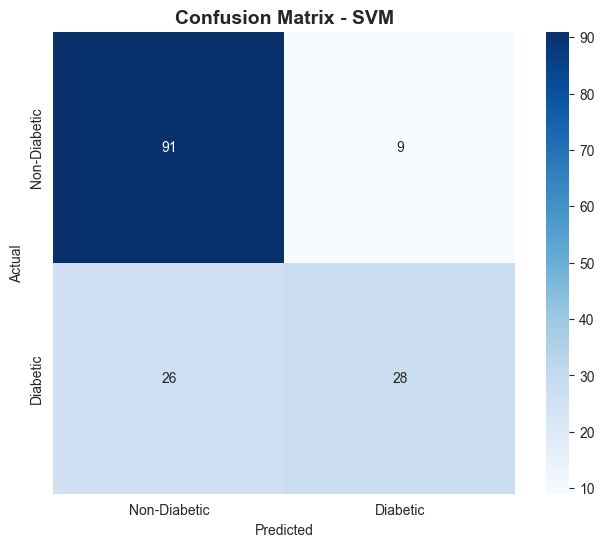

In [52]:
plt.figure(figsize=(8,6))
sns.heatmap(ConfusionMatrix_svm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix - SVM', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plotting the confusion matrix as a heatmap
# Darker blue indicates higher number of predictions in that cell

# Model 2 - RandomForestClassifier

In [53]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=2)
rf_model.fit(x_train, y_train)

# now we are going to train random forest
# Random Forest works like consulting 100 "doctors" (decision trees) and taking the majority vote
# n_estimators=100 means we are creating 100 decision trees in the forest

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [54]:
y_pred_rf = rf_model.predict(x_test)

## Now evaluating our random forest the same way

In [55]:
# calculating accuracy score for the Random Forest model

AccuracyScore_rf = accuracy_score(y_test, y_pred_rf)
AccuracyScore_rf

# accuracy tells us how many predictions the model got correct out of all test samples

0.7077922077922078

In [56]:
# calculating precision, recall, and F1-score for the Random Forest model

PrecisionScore_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(PrecisionScore_rf)
print(recall_rf)
print(f1_rf)

# precision = how many predicted diabetics were actually diabetic
# recall = how many actual diabetics were correctly identified
# F1-score = balance between precision and recall

0.6046511627906976
0.48148148148148145
0.5360824742268041


In [57]:
ConfusionMatrix_rf = confusion_matrix(y_test, y_pred_rf)
print(ConfusionMatrix_rf)

[[83 17]
 [28 26]]


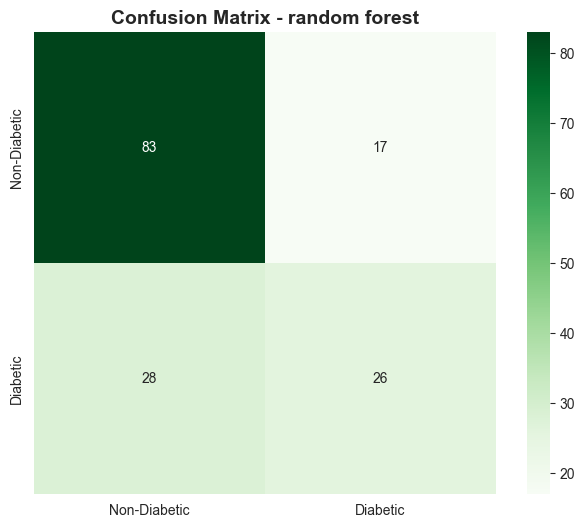

In [58]:
plt.figure(figsize=(8,6))
sns.heatmap(ConfusionMatrix_rf, annot=True, fmt='d', cmap="Greens", square=True,
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic']
            )
plt.title('Confusion Matrix - random forest', fontsize=14, fontweight='bold')
plt.show()

# plotting the confusion matrix as a heatmap for Random Forest
# darker green means more predictions in that cell
# this helps us see where the model is predicting correctly and where it makes mistakes

# Compare SVM and RandomForest

In [59]:
print('SVM', AccuracyScore_svm)
print('Random Forest', AccuracyScore_rf)

# comparing test accuracy between SVM and Random Forest
# SVM is slightly better in this case
# but we should check multiple models
# because what works well for one problem might not work for another

SVM 0.7727272727272727
Random Forest 0.7077922077922078


In [60]:
joblib.dump(svm_model, 'diabetes_model.pkl')

# saving the trained SVM model to a file using pickle
# .pkl is the file format used by Python to save objects

['diabetes_model.pkl']

In [61]:
input_data = (5, 166, 72, 19, 175,  25.8, 0.587, 51)
input_num_array = np.asarray(input_data)
reshape= input_num_array.reshape(1, -1)

std_data = scaler.transform(reshape)
prediction = svm_model.predict(std_data)


# data of a patient: 5 pregnancies, 166 glucose, 72 blood pressure, 19 skin thickness
# high glucose and multiple pregnancies, this person might be at high risk
# converting the data to a numpy array and reshaping it
# model expects a 2D array with rows and columns
# here, reshape means one row with all the feature columns


In [62]:
prediction

# now our machine learning model is trained
# we can use it to make predictions on new patient data

array([1])